In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import scipy
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import scipy
from sklearn.manifold import TSNE
import seaborn as sn
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA

In [5]:
import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = 1 / ( 1 +  np.square( (D.copy() * beta - 10 )/1000 )) * np.pi*1000
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y



def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    #P = P[~np.isnan(P)]
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


In [7]:
#len(COP_df )

Unnamed: 0  Option_type  Ask  Bid  Option_price  Stock_price  Strike_price  \
0           0            1  0.2  0.0          0.09        79.54          45.0   

   Volatility  Volume  Time_to_maturity  Implied_volatility  Pdiff  
0    0.286563       4          0.123288            0.763674 -34.54

In [2]:
#OP_df['Pdiff'] = OP_df.apply(lambda x: int(x['Stock_price']) - int(x['Stock_price']), axis=1)
#dataread

OP_df = pd.read_csv('OptionData12110.csv')
OP_df=OP_df.dropna()
OP_df['Pdiff'] =  OP_df['Strike_price'] - OP_df['Stock_price'] 
COP_df = OP_df. loc[OP_df['Option_type'] == 1]
POP_df = OP_df.loc[OP_df['Option_type'] == 0]
OP_df.head(1)


def func(x):
    if x > 0 :
        return 'OTM'
    elif x < 0 :
        return 'ITM'
    else:
        return 'ATM'
    
def pfunc(x):
    if x > 0 :
        return 'PUT_ITM'
    elif x < 0 :
        return 'PUT_OTM'
    else:
        return 'PUT_ATM'

COP_df['Type'] = COP_df['Pdiff'].apply(func)
POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)

COP_df = COP_df.drop(['Pdiff'], axis = 1)
POP_df = POP_df.drop(['Pdiff'], axis = 1)

frames = [COP_df, POP_df]

df = pd.concat(frames)
df.head(1)

C:\Users\chsha\AppData\Local\Temp/ipykernel_9900/2546600547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COP_df['Type'] = COP_df['Pdiff'].apply(func)
C:\Users\chsha\AppData\Local\Temp/ipykernel_9900/2546600547.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)


Unnamed: 0  Option_type  Ask  Bid  Option_price  Stock_price  Strike_price  \
0           0            1  0.2  0.0          0.09        79.54          45.0   

   Volatility  Volume  Time_to_maturity  Implied_volatility Type  
0    0.286563       4          0.123288            0.763674  ITM

In [9]:
len(df)

12110

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


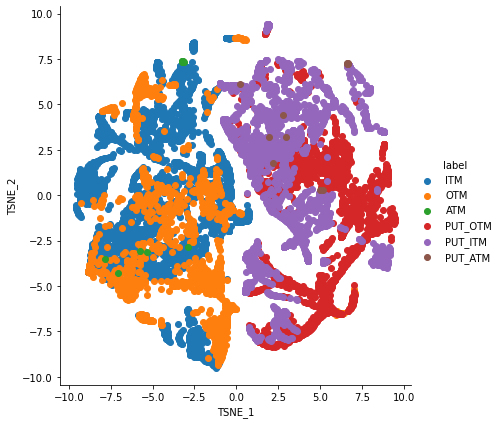

In [15]:
#TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Type)
df['cat'] = le.transform(df.Type)

l = df.Type

data = df.drop(['Type'], axis = 1)

s_data = StandardScaler().fit_transform(data)

model = TSNE(n_components = 2 , perplexity=60, metric='euclidean', learning_rate=1)

tsne_data = model.fit_transform(s_data)

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


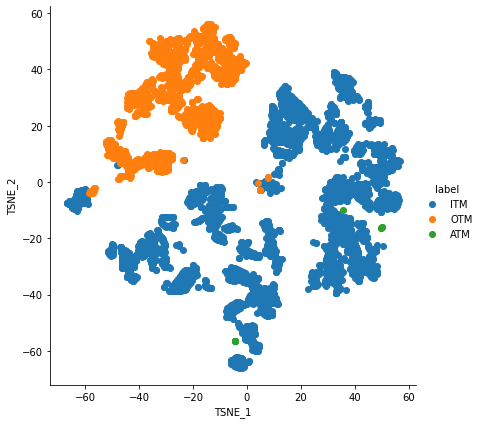

In [13]:
#TSNE


le = preprocessing.LabelEncoder()
le.fit(COP_df.Type)
COP_df['cat'] = le.transform(COP_df.Type)

l = COP_df.Type

data = COP_df.drop(['Type'], axis = 1)

s_data = StandardScaler().fit_transform(data)

model = TSNE(n_components = 2 , perplexity=60.0, random_state = 0, metric='euclidean', learning_rate=100)

tsne_data = model.fit_transform(s_data)

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

In [13]:
np.shape(tsne_data )

(200, 2)

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


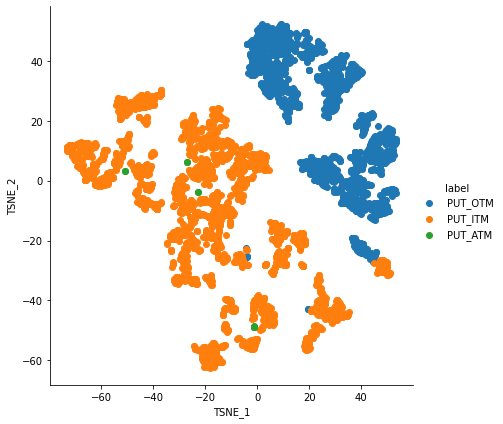

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


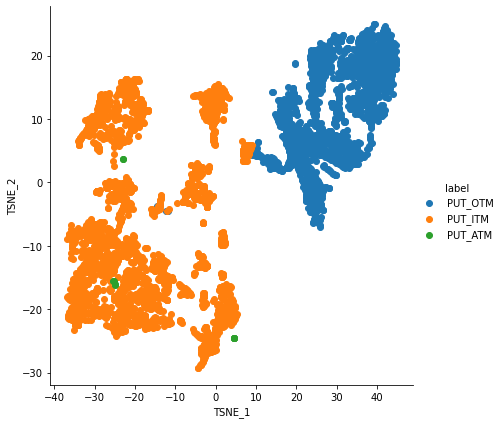

In [14]:
#TSNE


le = preprocessing.LabelEncoder()
le.fit(POP_df.Type)
POP_df['cat'] = le.transform(POP_df.Type)

l = POP_df.Type

data = POP_df.drop(['Type'], axis = 1)

s_data = StandardScaler().fit_transform(data)

model = TSNE(n_components = 2 , perplexity=60.0, random_state = 0, metric='euclidean', learning_rate=100)

tsne_data = model.fit_transform(s_data)

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

s_data = StandardScaler().fit_transform(data)

model = TSNE(n_components = 2 , perplexity=200.0, random_state = 0, metric='euclidean', learning_rate=100)

tsne_data = model.fit_transform(s_data)

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def doPCA(data):
  
  norm = StandardScaler().fit_transform(data)
  pca = PCA()
  newdata = pca.fit_transform(norm)
  return newdata,pca

#a,b = doPCA(SP_df)

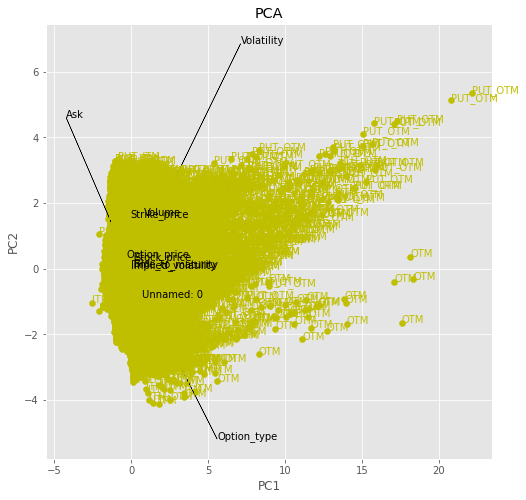

In [11]:
def DD(data):
    
    d = data
    
    data = data.drop(['Type'], axis = 1)
    
    
    n,pca = doPCA(data)
    PC = pca.components_
    PC_df = pd.DataFrame(data=PC, index = data.columns)

    plt.style.use('ggplot')
    fig=plt.figure(figsize=(8,8))

    for i in range(len(n)):
        plt.scatter(n[i,0],n[i,1], c = 'y')
        plt.text(n[i,0],n[i,1],d.Type[i], c = 'y')

    sc = 10
    for k in range(PC_df.shape[1]):
        plt.text(  PC_df.iloc[k,0]*sc + .05  ,  PC_df.iloc[k,1]*sc + .05 , PC_df.index[k] , c= 'k')
        plt.arrow( 0,0,  PC_df.iloc[k,0]*sc + .05  ,  PC_df.iloc[k,1]*sc + .05   , color= 'k')
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA")
    plt.show()
    
DD(df)

UMAP(min_dist=1, n_neighbors=30, random_state=420, verbose=True)
Sun Apr  3 19:38:42 2022 Construct fuzzy simplicial set
Sun Apr  3 19:38:42 2022 Finding Nearest Neighbors
Sun Apr  3 19:38:42 2022 Building RP forest with 11 trees
Sun Apr  3 19:38:42 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Sun Apr  3 19:38:43 2022 Finished Nearest Neighbor Search
Sun Apr  3 19:38:43 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Apr  3 19:39:09 2022 Finished embedding


C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


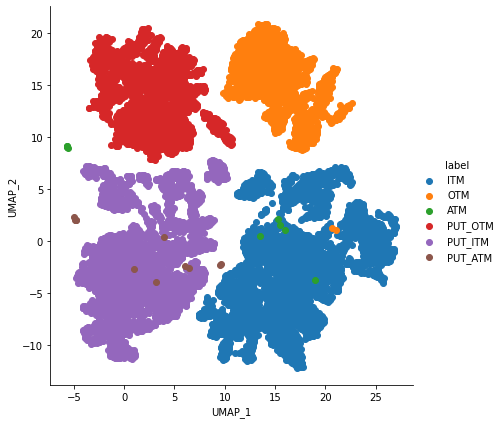

In [19]:
from umap import UMAP
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Type)
df['cat'] = le.transform(df.Type)
data = df
data = data.drop(['Type'], axis = 1)
norm = StandardScaler().fit_transform(data)
ump = UMAP(n_neighbors=30, min_dist=1, random_state=420, verbose=True)
Xumap = ump.fit_transform(norm,df.cat)
np.shape(Xumap)
n = Xumap
np.shape(n)
l = df.Type

tsne_data = np.vstack((n.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("UMAP_1", "UMAP_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'UMAP_1', 'UMAP_2').add_legend()

UMAP(min_dist=1, n_neighbors=30, random_state=420, verbose=True)
Mon Apr  4 21:13:47 2022 Construct fuzzy simplicial set
Mon Apr  4 21:13:47 2022 Finding Nearest Neighbors
Mon Apr  4 21:13:47 2022 Building RP forest with 9 trees
Mon Apr  4 21:13:47 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Mon Apr  4 21:13:48 2022 Finished Nearest Neighbor Search
Mon Apr  4 21:13:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr  4 21:14:19 2022 Finished embedding


C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


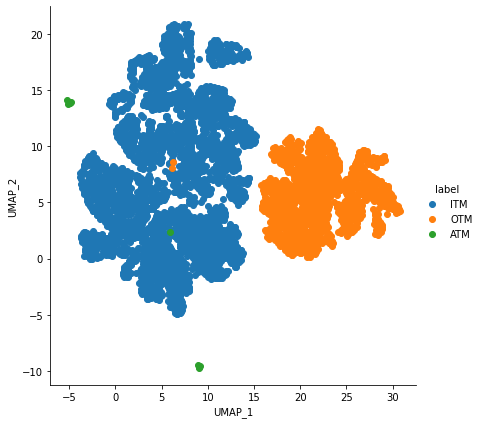

In [17]:
from umap import UMAP
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(COP_df.Type)
COP_df['cat'] = le.transform(COP_df.Type)
data = COP_df
data = data.drop(['Type'], axis = 1)
norm = StandardScaler().fit_transform(data)
ump = UMAP(n_neighbors=30, min_dist=1, random_state=420, verbose=True)
Xumap = ump.fit_transform(norm,COP_df.cat)
np.shape(Xumap)
n = Xumap
np.shape(n)
l = COP_df.Type

tsne_data = np.vstack((n.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("UMAP_1", "UMAP_2", "label"))
# COP_
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'UMAP_1', 'UMAP_2').add_legend()

UMAP(min_dist=1, n_neighbors=30, random_state=420, verbose=True)
Mon Apr  4 21:16:26 2022 Construct fuzzy simplicial set
Mon Apr  4 21:16:26 2022 Finding Nearest Neighbors
Mon Apr  4 21:16:26 2022 Building RP forest with 9 trees
Mon Apr  4 21:16:26 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Apr  4 21:16:26 2022 Finished Nearest Neighbor Search
Mon Apr  4 21:16:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr  4 21:16:57 2022 Finished embedding


C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


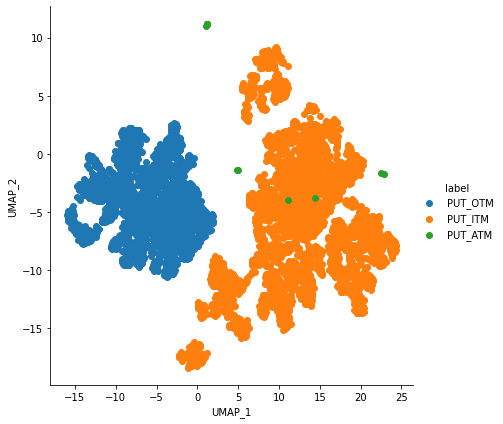

In [18]:
from umap import UMAP
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(POP_df.Type)
POP_df['cat'] = le.transform(POP_df.Type)
data = POP_df
data = data.drop(['Type'], axis = 1)
norm = StandardScaler().fit_transform(data)
ump = UMAP(n_neighbors=30, min_dist=1, random_state=420, verbose=True)
Xumap = ump.fit_transform(norm,POP_df.cat)
np.shape(Xumap)
n = Xumap
np.shape(n)
l = POP_df.Type

tsne_data = np.vstack((n.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("UMAP_1", "UMAP_2", "label"))
# COP_
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'UMAP_1', 'UMAP_2').add_legend()

In [2]:
#dataread
from sklearn import preprocessing

OP_df = pd.read_csv('OptionData12110.csv')
OP_df=OP_df.dropna()
OP_df['Pdiff'] =  OP_df['Strike_price'] - OP_df['Stock_price'] 
COP_df = OP_df. loc[OP_df['Option_type'] == 1]
POP_df = OP_df.loc[OP_df['Option_type'] == 0]

#OP_df['Pdiff'] = OP_df.apply(lambda x: int(x['Stock_price']) - int(x['Stock_price']), axis=1)
def func(x):
    if x > 0 :
        return 'OTM'
    elif x < 0 :
        return 'ITM'
    else:
        return 'ATM'
    
def pfunc(x):
    if x > 0 :
        return 'PUT_ITM'
    elif x < 0 :
        return 'PUT_OTM'
    else:
        return 'PUT_ATM'

COP_df['Type'] = COP_df['Pdiff'].apply(func)
POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)

COP_df = COP_df.drop(['Pdiff'], axis = 1)
POP_df = POP_df.drop(['Pdiff'], axis = 1)

def func(x):
    if x == 'ATM' :
        return 'ITM'
    
    elif x == 'PUT_ATM' :
        return 'PUT_ITM'
    else:
        return x

COP_df['Type'] = COP_df['Type'].apply(func)
POP_df['Type'] = POP_df['Type'].apply(func)

le = preprocessing.LabelEncoder()
le.fit(COP_df.Type)
COP_df['cat'] = le.transform(COP_df.Type)

le.fit(POP_df.Type)
POP_df['cat'] = le.transform(POP_df.Type)

frames = [COP_df, POP_df]

df = pd.concat(frames)
df.head(1)

C:\Users\chsha\AppData\Local\Temp/ipykernel_12848/2645382784.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  COP_df['Type'] = COP_df['Pdiff'].apply(func)
C:\Users\chsha\AppData\Local\Temp/ipykernel_12848/2645382784.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POP_df['Type'] = POP_df['Pdiff'].apply(pfunc)


Unnamed: 0  Option_type  Ask  Bid  Option_price  Stock_price  Strike_price  \
0           0            1  0.2  0.0          0.09        79.54          45.0   

   Volatility  Volume  Time_to_maturity  Implied_volatility Type  cat  
0    0.286563       4          0.123288            0.763674  ITM    0

In [38]:
df.head(2)

(799, 11)

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler    
def metric(p,t):
    mse = mean_squared_error(t,p)
    
    r = r2_score( t , p ,  multioutput='variance_weighted')
    
    return mse,r

In [4]:
from sklearn.model_selection import train_test_split
def predata(df):
    
    data = df
    data = data.drop(['Type'], axis = 1)
    label = np.array(data.Implied_volatility)
    data = data.drop(['Implied_volatility'], axis = 1)
    data = np.array(StandardScaler().fit_transform(data))

    X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.20, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [5]:
#Total Data

X_train, X_test, Y_train, Y_test = predata(df)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
 
# defining parameter range
X_train, X_test, Y_train, Y_test = predata(df)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, Y_train)
pred = regr.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.016226754939291363  2. R2:  0.5359917905590073


In [12]:
#ITM Data

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 0])
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
 
# defining parameter range
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, Y_train)
pred = regr.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.014036382482041858  2. R2:  0.588525291623401


In [13]:
#OTM Data

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 1])
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
 
# defining parameter range
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, Y_train)
pred = regr.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.01746852801976977  2. R2:  0.5666898019513156


In [6]:
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, Y_train, Y_test = predata(df)
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, Y_train)
pred = neigh.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.010349335501640789  2. R2:  0.7040581032383448


In [15]:
#from sklearn.neighbors import KNeighborsClassifier. loc[df['cat'] == 0
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 0])
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, Y_train)
pred = neigh.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.01007707724861122  2. R2:  0.704591804372263


In [16]:
#from sklearn.neighbors import KNeighborsClassifier. loc[df['cat'] == 0
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 1])
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, Y_train)
pred = neigh.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.01698161722847595  2. R2:  0.578767717799107


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df)
X_train, Y_train = make_regression(n_features=11)

clf = RandomForestRegressor(max_depth=2, random_state=1)

clf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=2, random_state=1)

In [19]:
pred = clf.predict(X_test)
mse_clf,r2_clf = metric(pred,Y_test)
print("1. MSE 2. R2  " , mse_clf,r2_clf  )

1. MSE 2. R2   7221.205880976808 -206491.22986189643


In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df)
mlp= MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter =1e7)

mlp.fit(X_train, Y_train)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.011103774592622236  2. R2:  0.6824847243928345


In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 0])
mlp= MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter =1e7)

mlp.fit(X_train, Y_train)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)


1. MSE:  0.008161537184342886  2. R2:  0.760745609694747


In [22]:

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df.loc[df['cat'] == 1])
mlp= MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter =1e7)

mlp.fit(X_train, Y_train)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)

1. MSE:  0.012747412083849937  2. R2:  0.6837979909692465


In [8]:
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df)
bst = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, Y_train)
bst.score(X_test, Y_test)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)



1. MSE:  0.011103774592622236  2. R2:  0.6824847243928345


In [55]:
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 0])
bst = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, Y_train)
bst.score(X_test, Y_test)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)



1. MSE:  0.05815570622408339  2. R2:  -0.704826887526427


In [24]:
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

X_train, X_test, Y_train, Y_test = predata(df. loc[df['cat'] == 1])
bst = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, Y_train)
bst.score(X_test, Y_test)
pred = mlp.predict(X_test)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)



1. MSE:  0.012747412083849937  2. R2:  0.6837979909692465


Note: you may need to restart the kernel to use updated packages.


In [11]:
p1 = mlp.predict(X_test)
p2 = neigh.predict(X_test)
p3 = bst.predict(X_test)
p4 = regr.predict(X_test)

pred = np.mean([p1, p2, p3, p4], axis=0)
mse_svm,r2_svm= metric(pred,Y_test)
print("1. MSE: ", mse_svm ," 2. R2: " ,r2_svm)


1. MSE:  0.00951646417957406  2. R2:  0.7278742718002529


SVM 1. MSE 2. R2 :  3.445397482824486e-05 0.999014779774022


^C
Note: you may need to restart the kernel to use updated packages.


(35, 32, 32, 3)

(9, 32, 32, 3)

(9,)

In [7]:
#TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(COP_df.Type)
COP_df['cat'] = le.transform(COP_df.Type)

l = COP_df.Type

data = COP_df.drop(['Type'], axis = 1)

s_data = StandardScaler().fit_transform(data)

X = s_data


Y = tsne(X, 2, 90, 10.0)




Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 6041...
Computing P-values for point 500 of 6041...
Computing P-values for point 1000 of 6041...
Computing P-values for point 1500 of 6041...
Computing P-values for point 2000 of 6041...
Computing P-values for point 2500 of 6041...
Computing P-values for point 3000 of 6041...
Computing P-values for point 3500 of 6041...
Computing P-values for point 4000 of 6041...
Computing P-values for point 4500 of 6041...
Computing P-values for point 5000 of 6041...
Computing P-values for point 5500 of 6041...
Computing P-values for point 6000 of 6041...
Mean value of sigma: 0.000000
Iteration 10: error is 24.290457
Iteration 20: error is 24.248589
Iteration 30: error is 22.462426
Iteration 40: error is 20.626370
Iteration 50: error is 19.934759
Iteration 60: error is 19.649170
Iteration 70: error is 19.490316
Iteration 80: error is 19.396594
Iteration 90: error is 19.328351
Iteration 100: error is 

C:\Users\chsha\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


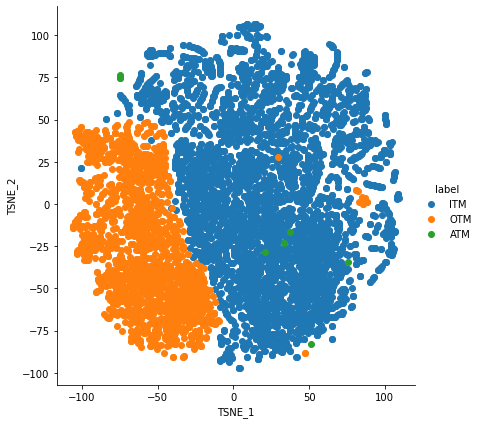

In [9]:

tsne_data = Y

tsne_data = np.vstack((tsne_data.T, l)).T

tsne_df = pd.DataFrame(data = tsne_data,columns =("TSNE_1", "TSNE_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'TSNE_1', 'TSNE_2').add_legend()
 
plt.show()